[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/johannesmelsbach/ai-im/blob/main/notebooks/01%20-%20Neural%20Network.ipynb)

![Logo Uni Köln](https://webmail.uni-koeln.de/themes/unikoeln/graphics/UzK_mittel.png)

# A simple Neural Network with Pytorch
PyTorch is an open-source machine learning framework and is widely used in research and in production.

In this notebook you will learn how to create a Neural Network with Pytorch that is able classify hand-written digits and does this with an accuracy of over 97%.

In [1]:
import torch
import torch.nn as nn
import numpy as np

There are four required building blocks when it comes to training a neural network:
* Data
* Model
* Loss Function 
* Optimizer

## Data
First of all we need data to train our network on. In the real world collecting and processing data is a very time consuming process. Luckily for us the research community published a lot of high quality datasets in the past that are ready to use for us.

In this notebook we will use the famous MNIST Dataset which consists of several thousand instances of handwritten digits with their coresponding labels.

 We download the dataset via the sklearn library. So we need to import sklearn and download the files

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
%%time
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

CPU times: user 11.5 s, sys: 66 ms, total: 11.5 s
Wall time: 11.5 s


 We downloaded the dataset and saved created the variables `X` containing the pictures and `y` containing the labels. Let's have a closer look at the data.

In [4]:
y.shape

(70000,)

`.shape` is a very useful command to see the dimensions of a vector or matrix. As we can see the shape of y is `(70000,)` which basically means it is a vector with 70000 rows. This means that we have 70000 labels and therefore 70000 examples in our dataset. Let's have a look at the first label:

In [5]:
y[0]

'5'

Next we look at the pictures of the digits which are stored in the `X` variable.

In [6]:
X.shape

(70000, 784)

The first dimension looks familiar. We had 70000 labels so it definitly makes sense to have 70000 images as well. You might have expected a three dimensional variable here, because images are a matrix of pixels. In this dataset the pictures are flattend into vectors with 784 dimensions. The original size of the images are 28x28 Pixels. 

If we want to look at the first picture of the dataset we have to reshape the images into a 28 by 28 matrix. We use `mathplotlib.pyplot.imshow()` to visualize the image.

In [7]:
import matplotlib.pyplot as plt

In [8]:
x0 = X[0]
x0 = x0.reshape([28,28])
x0.shape

(28, 28)

As you can see above currently the values range from 0 to 255. In Deep Learning we almost always want to have our input values to range from 0 to 1 instead. Scaling the data is very easy:

In [9]:
X = X / 255.0

Label:  5


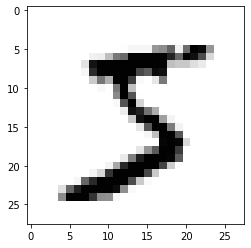

In [10]:
plt.imshow(x0.reshape(28,28), cmap='Greys')
# print the corresponding label
print("Label: ", y[0])

### Datasets and Dataloaders

In [11]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [12]:
y = y.astype('int8')

In [13]:
class MNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float() / 255.
        self.y = torch.tensor(y).long()

    def __len__(self):
        return len(self.y)
  
    def __getitem__(self, index):
        return (self.X[index], self.y[index])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [15]:
mnist_train = MNISTDataset(X_train, y_train)

In [16]:
mnist_test = MNISTDataset(X_test, y_test)

In [17]:
train_dl = DataLoader(mnist_train, batch_size=128) 

In [18]:
test_dl = DataLoader(mnist_test, batch_size=128)

## The Neural Network

In [19]:
import torch.nn.functional as F

In [20]:
class NeuralNetworkV1(nn.Module):
    def __init__(self):
        super(NeuralNetworkV1, self).__init__()
        self.l1 = nn.Linear(784,500)
        self.l2 = nn.Linear(500, 10)

    def forward(self, X):
        X = F.relu(self.l1(X))
        X = self.l2(X)
        return X

In [21]:
net1 = NeuralNetworkV1()

In [22]:
%%time
output = net1(mnist_train[0][0])
print(output)
print(output.shape)

tensor([ 0.0071,  0.0309, -0.0272,  0.0306,  0.0446,  0.0228, -0.0031,  0.0337,
         0.0177, -0.0013], grad_fn=<AddBackward0>)
torch.Size([10])
CPU times: user 3.52 ms, sys: 0 ns, total: 3.52 ms
Wall time: 1.98 ms


This was one forward pass through our neural network. We get an output of shape `[10]` but of quite random positive and negative numbers.

Instead of random numbers we want our network to output a probability distribution, where hopefully the correct number has the highest probability. We have to modify our output in a way that it outputs probabilities, which implies to properties:
1. Each output *must* be between `0` and `1`
2. All outputs have to add up to `1` in total


💭 Think a moment why all outputs have to add up to `1` in our the digit classification example.

In [23]:
def softmax(x):
    return x.exp() / x.exp().sum()

In [24]:
class NeuralNetworkV2(nn.Module):
    def __init__(self):
        super(NeuralNetworkV2, self).__init__()
        self.l1 = nn.Linear(784,200)
        self.l2 = nn.Linear(200, 10)


    def forward(self, X):
        X = F.sigmoid(self.l1(X))
        X = self.l2(X)
        
        return X

$$
\text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}
$$

In [25]:
net2 = NeuralNetworkV2()

In [26]:
%%time
output = net2(torch.tensor(X[0]).float() / 256)
output

CPU times: user 2.15 ms, sys: 97 µs, total: 2.25 ms
Wall time: 1.3 ms


/home/johannes/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([ 0.5441,  0.0806, -0.1505, -0.2918,  0.2872, -0.2501,  0.0257,  0.2772,
        -0.0252, -0.3018], grad_fn=<AddBackward0>)

As you can see we reached our goal. Every output is a number between zero and one and all outputs add up to 1. However, all outputs probabilities are about the same at about `0.1`. Which basically means that our network has no idea which digit is shown here. And how should it? It hasn't learned anything yet.

## Loss Function

We need a way to see how good or how bad our neural net is doing. When you take a look in the documentation of the `nn.CrossEntropyLoss()`

In [27]:
loss_func = nn.CrossEntropyLoss()

## Optimizer

In [28]:
from torch import optim

In [29]:
optimizer = optim.Adam(net2.parameters(), lr=0.001)

## Training Loop

In [30]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [31]:
epochs = 100

In [32]:
for epoch in range(epochs):
    net2.train()
    total_loss = 0
    train_acc = 0
    for inputs, labels in train_dl:
        
        preds = net2(inputs)
        loss = loss_func(preds, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss
        train_acc += accuracy(preds, labels)
        
    
    net2.eval()
    train_acc /= len(train_dl)
    print(f"train_acc: {train_acc}")
    #print(f"Train Loss: {total_loss}")
    with torch.no_grad():
        val_acc = 0
        for inputs_test, labels_test in test_dl:
            val_acc += accuracy(net2(inputs_test), labels_test)
        val_acc /= len(test_dl)
        print(f"val_acc: {val_acc}")

train_acc: 0.14842990040779114
val_acc: 0.29243195056915283
train_acc: 0.3338845670223236
val_acc: 0.3561815619468689
train_acc: 0.5017715692520142
val_acc: 0.5528775453567505
train_acc: 0.6194038987159729
val_acc: 0.6510607004165649
train_acc: 0.7010074853897095
val_acc: 0.7181202173233032
train_acc: 0.7552083134651184
val_acc: 0.7623596787452698
train_acc: 0.7901725769042969
val_acc: 0.7943509817123413
train_acc: 0.813819169998169
val_acc: 0.8168984055519104
train_acc: 0.8307861685752869
val_acc: 0.8331283926963806
train_acc: 0.8431417346000671
val_acc: 0.8455252647399902
train_acc: 0.8532162308692932
val_acc: 0.8543865084648132
train_acc: 0.8627014756202698
val_acc: 0.8629403114318848
train_acc: 0.8697232007980347
val_acc: 0.8692924976348877
train_acc: 0.8752927184104919
val_acc: 0.8735347390174866
train_acc: 0.8798167109489441
val_acc: 0.876807451248169
train_acc: 0.8837894797325134
val_acc: 0.8800008893013
train_acc: 0.8869335651397705
val_acc: 0.8838785886764526
train_acc: 0.8899

In [ ]:
accuracy(net2(mnist_test[0:8][0]), mnist_test[0:8][1])

In [ ]:
mnist_test[0:8][0]

In [ ]:
mnist_test[0:8][1]

In [ ]:
len(test_dl)